# Machine Learning Models with All Features

This notebook implements and compares multiple machine learning models using all available features in the dataset.

In [15]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# ML models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Set random seed for reproducibility
np.random.seed(42)

## Load and Explore the Dataset

In [16]:
# Load the dataset
datas = pd.read_csv('SHR65_23 copy.csv')
data = datas.head(100000)
# Display basic info about the dataset
print("Dataset Shape:", data.shape)
data.head()

C:\Users\Anush Pranav\AppData\Local\Temp\ipykernel_8384\2276257744.py:2: DtypeWarning: Columns (8,10,14,18,26,27,28) have mixed types. Specify dtype option on import or set low_memory=False.
  datas = pd.read_csv('SHR65_23 copy.csv')


Dataset Shape: (100000, 30)


,ID,CNTYFIPS,Ori,State,Agency,Agentype,Source,Solved,Year,Month,...,OffRace,OffEthnic,Weapon,Relationship,Circumstance,Subcircum,VicCount,OffCount,FileDate,MSA
0,197603001AK00101,"Anchorage, AK",AK00101,Alaska,Anchorage,Municipal police,FBI,Yes,1976,March,...,Black,Unknown or not reported,"Handgun - pistol, revolver, etc",Relationship not determined,Other arguments,NaN,0,0,30180.0,"Anchorage, AK"
1,197604001AK00101,"Anchorage, AK",AK00101,Alaska,Anchorage,Municipal police,FBI,Yes,1976,April,...,White,Unknown or not reported,"Handgun - pistol, revolver, etc",Girlfriend,Other arguments,NaN,0,0,30180.0,"Anchorage, AK"
2,197606001AK00101,"Anchorage, AK",AK00101,Alaska,Anchorage,Municipal police,FBI,Yes,1976,June,...,Black,Unknown or not reported,"Handgun - pistol, revolver, etc",Stranger,Other,NaN,0,0,30180.0,"Anchorage, AK"
3,197606002AK00101,"Anchorage, AK",AK00101,Alaska,Anchorage,Municipal police,FBI,Yes,1976,June,...,White,Unknown or not reported,"Handgun - pistol, revolver, etc",Other - known to victim,Other arguments,NaN,0,0,30180.0,"Anchorage, AK"
4,197607001AK00101,"Anchorage, AK",AK00101,Alaska,Anchorage,Municipal police,FBI,Yes,1976,July,...,American Indian or Alaskan Native,Unknown or not reported,Knife or cutting instrument,Brother,Other arguments,NaN,0,0,30180.0,"Anchorage, AK"


In [17]:
# Check for missing values
missing_values = data.isnull().sum()
print("Missing Values:")
print(missing_values[missing_values > 0])

Missing Values:
CNTYFIPS          716
Ori               297
State             322
Agency            702
Agentype         1516
Source           1493
Solved           2242
Year              423
Month             776
Incident          769
ActionType       1523
Homicide         1636
Situation        1749
VicAge           3043
VicSex           1797
VicRace          2235
VicEthnic        3062
OffAge           4607
OffSex           3785
OffRace          3708
OffEthnic        4390
Weapon           2252
Relationship     2928
Circumstance     2755
Subcircum       96916
VicCount         1476
OffCount         2199
FileDate         2220
MSA              1488
dtype: int64


In [18]:
# Display data types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 30 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   ID            100000 non-null  object
 1   CNTYFIPS      99284 non-null   object
 2   Ori           99703 non-null   object
 3   State         99678 non-null   object
 4   Agency        99298 non-null   object
 5   Agentype      98484 non-null   object
 6   Source        98507 non-null   object
 7   Solved        97758 non-null   object
 8   Year          99577 non-null   object
 9   Month         99224 non-null   object
 10  Incident      99231 non-null   object
 11  ActionType    98477 non-null   object
 12  Homicide      98364 non-null   object
 13  Situation     98251 non-null   object
 14  VicAge        96957 non-null   object
 15  VicSex        98203 non-null   object
 16  VicRace       97765 non-null   object
 17  VicEthnic     96938 non-null   object
 18  OffAge        95393 non-n

## Data Preprocessing

In [19]:
# Define feature and target variables
# Assuming we're predicting whether a case was solved ('Solved')
# If you need to predict something else, adjust accordingly
X = data.drop(['Solved', 'ID', 'CNTYFIPS', 'Ori'], axis=1)  # Dropping ID columns and the target
y = data['Solved']

# Convert target to binary if it's not already
if y.dtype == 'object':
    le = LabelEncoder()
    y = le.fit_transform(y)
    print(f"Target classes: {le.classes_}")

Target classes: ['No' 'Solved' 'Unknown' 'Yes' nan]


In [20]:
# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"Categorical columns: {len(categorical_cols)}")
print(f"Numerical columns: {len(numerical_cols)}")

Categorical columns: 26
Numerical columns: 0


In [21]:
if isinstance(y, pd.Series):
    # If y is a pandas Series, use isna()
    if y.isna().any():
        # Either drop rows with NaN target values
        mask = ~y.isna()
        X = X[mask]
        y = y[mask]
else:
    # If y is a numpy array, use np.isnan()
    if np.isnan(y).any():
        # Either drop rows with NaN target values
        mask = ~np.isnan(y)
        X = X[mask]
        y = y[mask]
        # Or alternatively fill them with a placeholder value
        # y = np.where(np.isnan(y), 'Unknown', y)

# 2. Check class distribution
if isinstance(y, pd.Series):
    class_counts = y.value_counts()
else:
    class_counts = pd.Series(y).value_counts()
    
print("Target class distribution:")
print(class_counts)

# 3. Handle classes with too few samples
min_samples_per_class = 2
classes_to_keep = class_counts[class_counts >= min_samples_per_class].index
print(f"Keeping classes with at least {min_samples_per_class} samples: {classes_to_keep.tolist()}")

# Filter dataset to only keep classes with sufficient samples
mask = pd.Series(y).isin(classes_to_keep)
X = X[mask]
y = y[mask]

# Now split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

# Ensure all columns are strings before preprocessing
for col in X_train.columns:
    X_train[col] = X_train[col].astype(str)
for col in X_test.columns:
    X_test[col] = X_test[col].astype(str)
    
# Create preprocessing pipelines
# For numerical features: impute missing values and scale
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# For categorical features: impute missing values and one-hot encode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Apply preprocessing
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print(f"Processed training data shape: {X_train_processed.shape}")
print(f"Processed testing data shape: {X_test_processed.shape}")

Target class distribution:
3    60255
0    28345
2     9157
4     2242
1        1
Name: count, dtype: int64
Keeping classes with at least 2 samples: [3, 0, 2, 4]
Training set shape: (74999, 26)
Test set shape: (25000, 26)
Processed training data shape: (74999, 19181)
Processed testing data shape: (25000, 19181)


## Model Training and Evaluation

Let's train multiple ML models and compare their performance

In [22]:
# Define function to train and evaluate models
def train_and_evaluate(models, X_train, y_train, X_test, y_test):
    results = []
    
    for name, model in models.items():
        print(f"Training {name}...")
        
        # Check if the model is GaussianNB which requires dense input
        if isinstance(model, GaussianNB):
            # Convert sparse matrix to dense array if needed
            if hasattr(X_train, "toarray"):
                model.fit(X_train.toarray(), y_train)
                y_pred = model.predict(X_test.toarray())
            else:
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
        else:
            # For other models, use the data as is
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, output_dict=True)
        
        # Store results
        results.append({
            'Model': name,
            'Accuracy': accuracy,
            'Precision': report['weighted avg']['precision'],
            'Recall': report['weighted avg']['recall'],
            'F1-Score': report['weighted avg']['f1-score']
        })
        
        print(f"{name} - Accuracy: {accuracy:.4f}\n")
        
    return pd.DataFrame(results).sort_values('Accuracy', ascending=False).reset_index(drop=True)

In [ ]:
# Define models to train
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'AdaBoost': AdaBoostClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
    'Naive Bayes': GaussianNB(),
    'Neural Network': MLPClassifier(max_iter=1000, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss'),
    'LightGBM': LGBMClassifier(n_estimators=100, random_state=42),
    'CatBoost': CatBoostClassifier(n_estimators=100, random_state=42, verbose=0),
    'Extra Trees': ExtraTreesClassifier(n_estimators=100, random_state=42)
}

# Train and evaluate models
results = train_and_evaluate(models, X_train_processed, y_train, X_test_processed, y_test)

Training Logistic Regression...


Logistic Regression - Accuracy: 0.8430

Training Decision Tree...
Decision Tree - Accuracy: 0.8395

Training Random Forest...


C:\Users\Anush Pranav\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Anush Pranav\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Anush Pranav\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

Random Forest - Accuracy: 0.8457

Training Gradient Boosting...
Gradient Boosting - Accuracy: 0.8479

Training AdaBoost...


C:\Users\Anush Pranav\AppData\Roaming\Python\Python312\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost - Accuracy: 0.8208

Training SVM...


In [ ]:
# Display results
results

,Model,Accuracy,Precision,Recall,F1-Score
0,Decision Tree,0.873143,0.875060,0.873143,0.874072
1,Extra Trees,0.869714,0.871654,0.869714,0.870108
2,Random Forest,0.868000,0.857039,0.868000,0.860820
3,Gradient Boosting,0.864571,0.864817,0.864571,0.864238
4,XGBoost,0.863429,0.862239,0.863429,0.862420
5,LightGBM,0.863429,0.868450,0.863429,0.865596
6,SVM,0.859429,0.855599,0.859429,0.857301
7,CatBoost,0.857714,0.860056,0.857714,0.858765
8,K-Nearest Neighbors,0.842857,0.840075,0.842857,0.839577
9,Logistic Regression,0.837714,0.839772,0.837714,0.838721


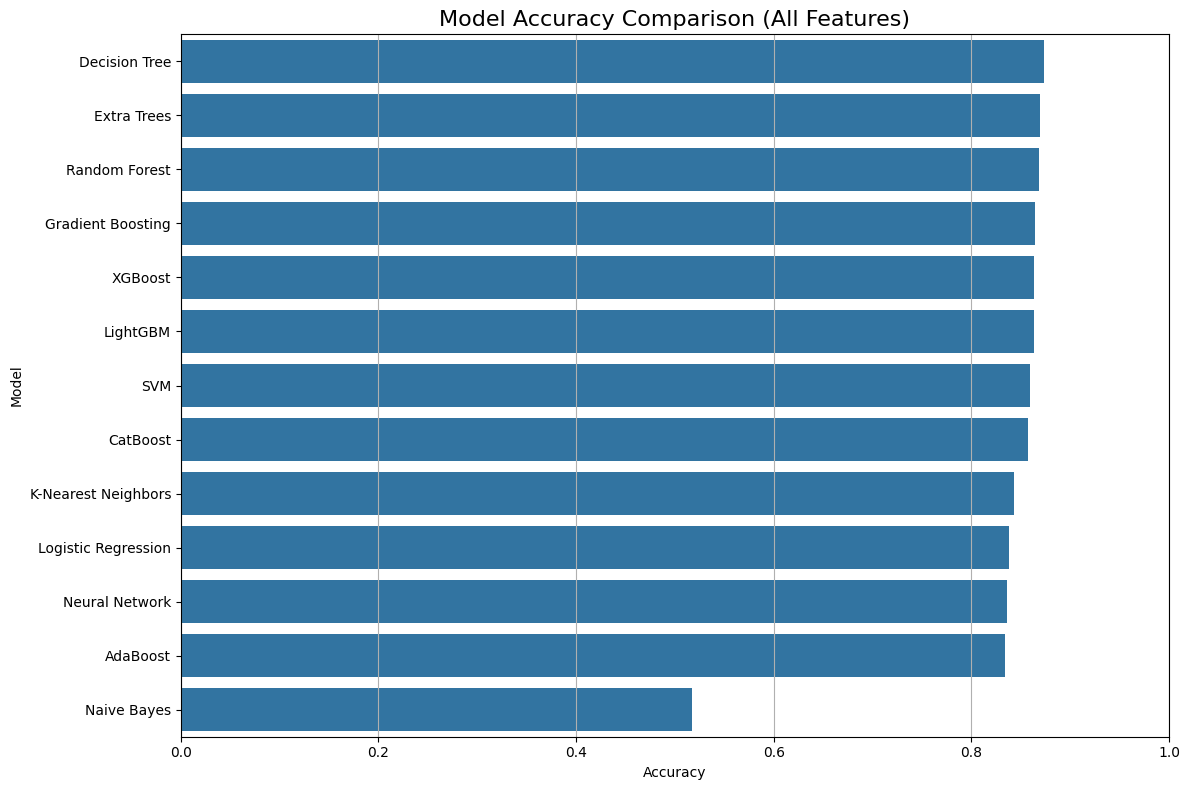

In [ ]:
# Visualize model performance
plt.figure(figsize=(12, 8))
sns.barplot(x='Accuracy', y='Model', data=results)
plt.title('Model Accuracy Comparison (All Features)', fontsize=16)
plt.xlim(0, 1)
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()

## Feature Importance Analysis

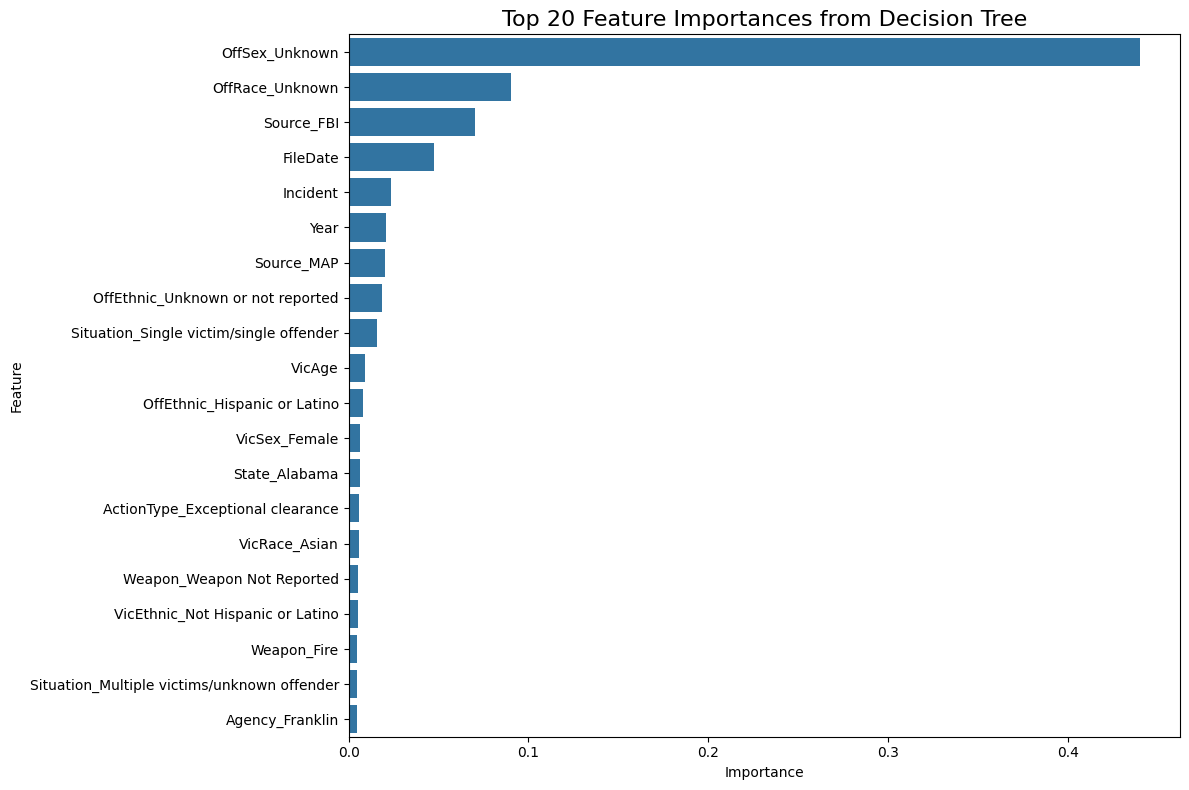

In [ ]:
# Get the best performing model
best_model_name = results.iloc[0]['Model']
best_model = models[best_model_name]

# Check if the model has feature importance attribute
if hasattr(best_model, 'feature_importances_'):
    # Get feature names after one-hot encoding
    feature_names = []
    for transformer_name, transformer, column_names in preprocessor.transformers_:
        if transformer_name == 'cat':
            # Get all categories from OneHotEncoder
            one_hot = transformer.named_steps['onehot']
            categories = one_hot.categories_
            for i, category in enumerate(categories):
                for cat_value in category:
                    feature_names.append(f"{column_names[i]}_{cat_value}")
        else:  # numerical features
            feature_names.extend(column_names)
    
    # Check if lengths match
    if len(feature_names) == len(best_model.feature_importances_):
        # Create feature importance dataframe
        importances = pd.DataFrame({
            'Feature': feature_names,
            'Importance': best_model.feature_importances_
        })
        importances = importances.sort_values('Importance', ascending=False).reset_index(drop=True)
        
        # Plot top 20 features
        plt.figure(figsize=(12, 8))
        sns.barplot(x='Importance', y='Feature', data=importances.head(20))
        plt.title(f'Top 20 Feature Importances from {best_model_name}', fontsize=16)
        plt.tight_layout()
        plt.show()
        
        # Display top 20 features
        importances.head(20)
    else:
        print(f"Feature name length ({len(feature_names)}) doesn't match feature importance length ({len(best_model.feature_importances_)})")
else:
    print(f"The best model {best_model_name} doesn't have feature_importances_ attribute.")

## Confusion Matrix for Best Model

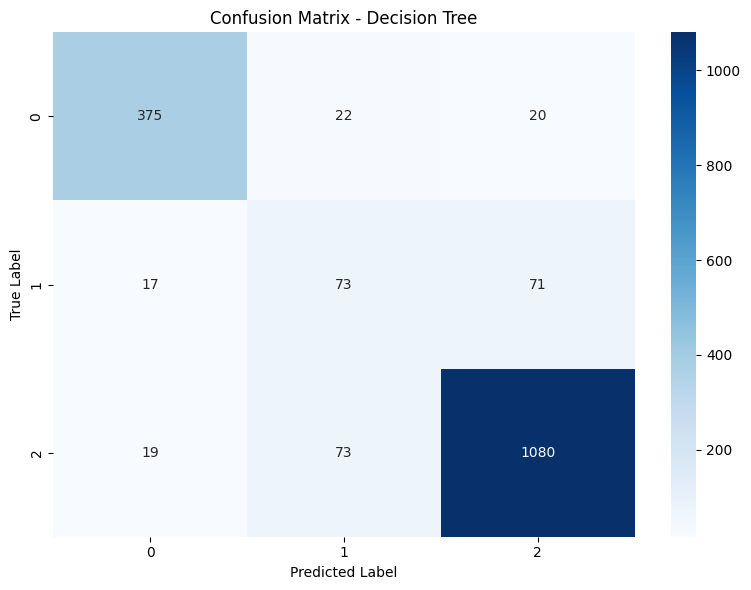

Classification Report for Decision Tree:
              precision    recall  f1-score   support

           0       0.91      0.90      0.91       417
           1       0.43      0.45      0.44       161
           2       0.92      0.92      0.92      1172

    accuracy                           0.87      1750
   macro avg       0.76      0.76      0.76      1750
weighted avg       0.88      0.87      0.87      1750



In [ ]:
# Get predictions from the best model
best_model = models[best_model_name]
y_pred = best_model.predict(X_test_processed)

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Display classification report
print(f"Classification Report for {best_model_name}:")
print(classification_report(y_test, y_pred))

## Cross-Validation for More Robust Evaluation

In [ ]:
# Perform 5-fold cross-validation on the best model
best_model = models[best_model_name]

# Create pipeline with preprocessing and the model
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', best_model)
])

# Perform cross-validation
cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')

print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean():.4f}")
print(f"Standard Deviation: {cv_scores.std():.4f}")

Cross-Validation Scores: [0.94       0.915      0.90857143 0.86142857 0.44285714]
Mean CV Accuracy: 0.8136
Standard Deviation: 0.1871


## Hyperparameter Tuning for the Best Model

In [ ]:
# Define hyperparameter grid for the best model
param_grid = {}

if best_model_name == 'Logistic Regression':
    param_grid = {
        'C': [0.1, 1, 10],
        'solver': ['liblinear', 'lbfgs'],
        'penalty': ['l1', 'l2']
    }
elif best_model_name == 'Random Forest':
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10]
    }
elif best_model_name == 'Gradient Boosting':
    param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    }
elif best_model_name == 'XGBoost':
    param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    }
elif best_model_name == 'SVM':
    param_grid = {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto']
    }
else:
    print(f"No hyperparameter grid defined for {best_model_name}. Using default parameters.")

# Perform grid search if param_grid is not empty
if param_grid:
    print(f"Performing GridSearchCV for {best_model_name}...")
    grid_search = GridSearchCV(best_model, param_grid, cv=3, scoring='accuracy')
    grid_search.fit(X_train_processed, y_train)
    
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validation score: {grid_search.best_score_:.4f}")
    
    # Evaluate with best parameters
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test_processed)
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"Accuracy with tuned hyperparameters: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

No hyperparameter grid defined for Decision Tree. Using default parameters.


## Summary and Conclusion

Model Performance Summary (All Features)

                  Model  Accuracy  Precision    Recall  F1-Score
0         Decision Tree  0.873143   0.875060  0.873143  0.874072
1           Extra Trees  0.869714   0.871654  0.869714  0.870108
2         Random Forest  0.868000   0.857039  0.868000  0.860820
3     Gradient Boosting  0.864571   0.864817  0.864571  0.864238
4               XGBoost  0.863429   0.862239  0.863429  0.862420
5              LightGBM  0.863429   0.868450  0.863429  0.865596
6                   SVM  0.859429   0.855599  0.859429  0.857301
7              CatBoost  0.857714   0.860056  0.857714  0.858765
8   K-Nearest Neighbors  0.842857   0.840075  0.842857  0.839577
9   Logistic Regression  0.837714   0.839772  0.837714  0.838721
10       Neural Network  0.836571   0.839287  0.836571  0.837819
11             AdaBoost  0.833714   0.834989  0.833714  0.834092
12          Naive Bayes  0.517143   0.751676  0.517143  0.552238

Best Model: Decision Tree with accuracy 0.8731


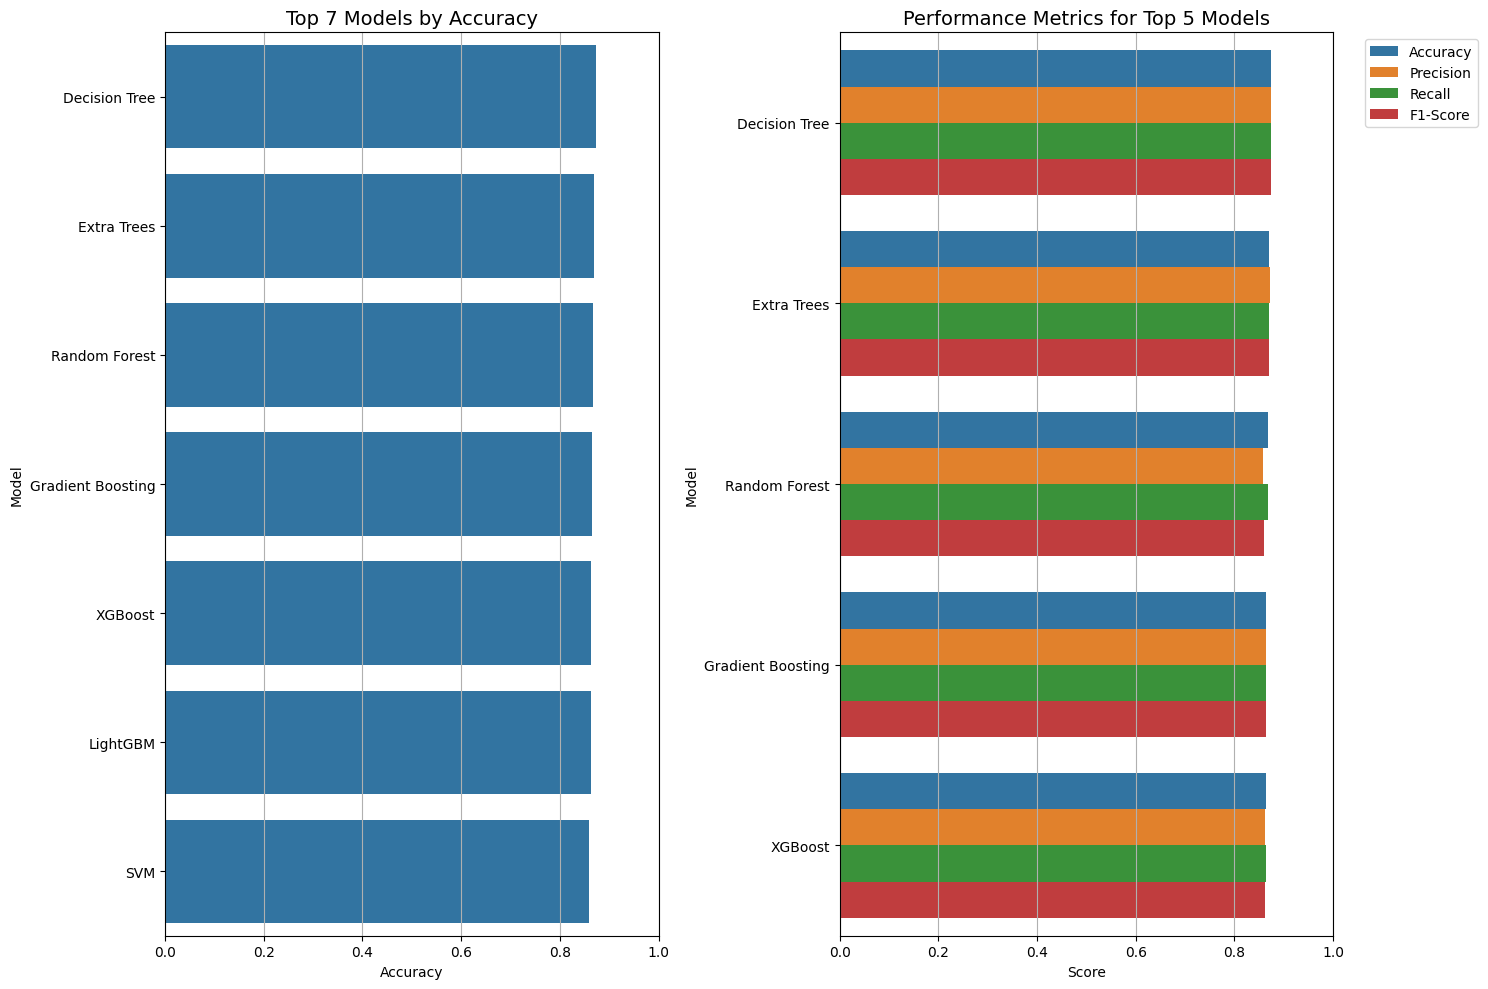

In [ ]:
# Print overall performance summary
print("Model Performance Summary (All Features)")
print("===========================================\n")
print(results)

print(f"\nBest Model: {best_model_name} with accuracy {results.iloc[0]['Accuracy']:.4f}")

# Create a final visualization
plt.figure(figsize=(15, 10))

plt.subplot(1, 2, 1)
sns.barplot(x='Accuracy', y='Model', data=results.head(7))
plt.title('Top 7 Models by Accuracy', fontsize=14)
plt.xlim(0, 1)
plt.grid(True, axis='x')

plt.subplot(1, 2, 2)
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
top_models = results.head(5)['Model'].tolist()
plot_data = pd.melt(results[results['Model'].isin(top_models)], 
                    id_vars='Model', 
                    value_vars=metrics, 
                    var_name='Metric', 
                    value_name='Score')
sns.barplot(x='Score', y='Model', hue='Metric', data=plot_data)
plt.title('Performance Metrics for Top 5 Models', fontsize=14)
plt.xlim(0, 1)
plt.grid(True, axis='x')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()